# DA3 Assignment 1
Nicolas Fernandez

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

In [52]:
# Importing dataset, printing shape and showing first 5 observations
data = pd.read_csv('https://raw.githubusercontent.com/nxfern/DA3_Assignment_1/main/morg-2014-emp.csv?token=GHSAT0AAAAAACMRYCRL35EAZDWCGJWYQ3KSZNKN6JA')
print(data.shape)
data.head()

(149316, 23)


,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
0,3,2600310997690,January,AL,3151.680,1692.000,40,43,1,NaN,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
1,5,75680310997590,January,AL,3457.114,450.000,40,41,2,NaN,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
2,6,75680310997590,January,AL,3936.911,1090.000,60,41,2,NaN,...,2,6,"Native, Born In US",63,Motor vehicles and motor vehicle equipment man...,8140,"Private, For Profit",No,No,Employed-At Work
3,10,179140131100930,January,AL,3288.364,769.230,40,40,1,NaN,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (...",8255,"Private, For Profit",Yes,NaN,Employed-At Work
4,11,179140131100930,January,AL,3422.850,826.920,40,43,1,NaN,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


## Selecting Occupation
Registered nurses were selected for an analysis of predictive models of hourly wage. The number of observations are 3455, occupation code 3255 per census data

In [53]:
# Selecting Registed Nurses as the occupation and assigning it to a new df rnurses, showing the amount of observations and checking column info
rnurses = data.loc[data['occ2012'] == 3255]
print(rnurses.shape)
rnurses.info()

(3455, 23)
<class 'pandas.core.frame.DataFrame'>
Index: 3455 entries, 37 to 149242
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3455 non-null   int64  
 1   hhid        3455 non-null   int64  
 2   intmonth    3455 non-null   object 
 3   stfips      3455 non-null   object 
 4   weight      3455 non-null   float64
 5   earnwke     3455 non-null   float64
 6   uhours      3455 non-null   int64  
 7   grade92     3455 non-null   int64  
 8   race        3455 non-null   int64  
 9   ethnic      191 non-null    float64
 10  age         3455 non-null   int64  
 11  sex         3455 non-null   int64  
 12  marital     3455 non-null   int64  
 13  ownchild    3455 non-null   int64  
 14  chldpres    3455 non-null   int64  
 15  prcitshp    3455 non-null   object 
 16  state       3455 non-null   object 
 17  ind02       3455 non-null   object 
 18  occ2012     3455 non-null   int64  
 19  class       3455 n

## Feature Engineering
Examination of data and creation of binary/dummy variables and/or transforming data

In [4]:
# Adding 'Missing' to ethnic column to prevent observations being lost to 'null' for regression analysis
rnurses['ethnic'] = rnurses['ethnic'].fillna('Missing')

In [5]:
# Creating hourly wage variable, and quadratic variable for age
rnurses['hrwage'] = rnurses['earnwke'] / rnurses['uhours']
rnurses['agesq'] = rnurses['age'] ** 2

In [6]:
# Checking race column value counts
rnurses['race'].value_counts()

race
1     2837
2      320
4      249
5       12
3       11
6        8
7        8
8        3
9        3
13       1
21       1
16       1
10       1
Name: count, dtype: int64

In [7]:
# According to dataset, 1=white, 2=black, and 4=asian. Creating dummy variables to account for black and asian
rnurses['black'] = (rnurses['race'] == 2).astype(int)
rnurses['asian'] = (rnurses['race'] == 4).astype(int)

In [8]:
# Checking sex column value counts
rnurses['sex'].value_counts()

sex
2    3125
1     330
Name: count, dtype: int64

In [9]:
# 1 = male, 2 = female. Creating `female` dummy variable
rnurses['female'] = (rnurses['sex'] == 2).astype(int)

In [10]:
# Chceking ownchild value counts
rnurses.ownchild.value_counts()

ownchild
0    2009
2     569
1     566
3     246
4      54
5       9
6       2
Name: count, dtype: int64

In [11]:
# Creating dummy variables for number of children present
rnurses['one_child'] = (rnurses['ownchild'] == 1).astype(int) # 1 if one child present 0 if not
rnurses['two_child'] = (rnurses['ownchild'] == 2).astype(int) # 1 if two children present 0 if not
rnurses['three_plus_child'] = (rnurses['ownchild'] >= 3).astype(int) # 1 if three or more childred present 0 if not

In [12]:
# Checking marital value counts
rnurses.marital.value_counts()

marital
1    2212
7     590
5     462
6      71
4      54
3      38
2      28
Name: count, dtype: int64

In [13]:
# Numers are defined as follows: 1 and 2 = married, 3 and 6 = separated, 4 = widowed, 5 = divorced, and 7 = never married

# Creating dummy variable for currently single which includes the values for 3, 6 (separated), 5 (divorced)
rnurses['now_single'] = rnurses['marital'].isin([3, 5, 6]).astype(int)

# Creating dummy variable for 7 (never married)
rnurses['never_married'] = (rnurses['marital'] == 7).astype(int)

In [14]:
# Checking grade92 column value counts
rnurses.grade92.value_counts()

grade92
43    1888
42     624
41     485
44     256
40      97
39      44
45      38
46      16
38       2
33       1
34       1
31       1
37       1
35       1
Name: count, dtype: int64

In [15]:
# This column measures the amount of education. 43 = bachelors degree, >43 is graduate and/or phd, 41 and 42 are associate degrees, and <41 is college not completed

# Creating dummy variable for associate degrees
rnurses['associate'] = rnurses['grade92'].isin([41, 42]).astype(int)

# Creating dummy variable for higher level education (above 43)
rnurses['higher_edu'] = (rnurses['grade92'] > 43).astype(int)

# Creating dummy variable for below bachelors and associate (below 41)
rnurses['no_degree'] = (rnurses['grade92'] < 41).astype(int)

In [16]:
# Checking prcitshp value counts
rnurses.prcitshp.value_counts()

prcitshp
Native, Born In US                        3012
Foreign Born, US Cit By Naturalization     307
Foreign Born, Not a US Citizen              98
Native, Born Abroad Of US Parent(s)         31
Native, Born in PR or US Outlying Area       7
Name: count, dtype: int64

The column prcitshp shows whether or not the person in question is a native citizen, naturalized, or not a US citizen. Not deemed to be significant for this analysis given low amount of observations of non-US citizens

In [17]:
# Checking unionmme value counts
rnurses.unionmme.value_counts()

unionmme
No     2845
Yes     610
Name: count, dtype: int64

In [18]:
# This checks whether or not the person in question is a member of a union or some union-type entity. Changing this column to a binary variable with 'Yes' = 1
rnurses['unionmme'] = (rnurses['unionmme'] == 'Yes').astype(int)

## Charts
#### Wage Distribution Check

In [19]:
# Adding magic command for matplotlib
%matplotlib inline

In [20]:
# Descriptive stats for hourly wage
rnurses['hrwage'].describe()

count    3455.000000
mean       30.222456
std        14.427157
min         0.000937
25%        21.000000
50%        28.500000
75%        36.961500
max       293.268750
Name: hrwage, dtype: float64

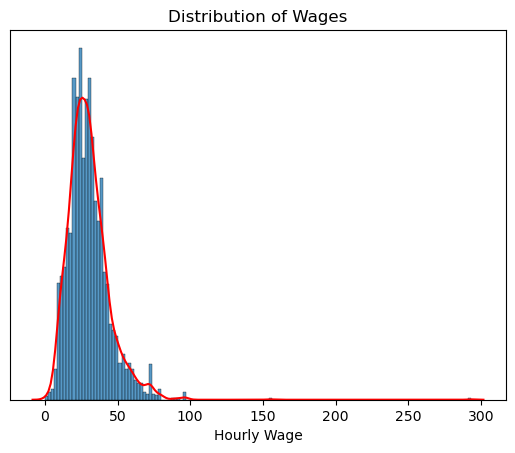

In [21]:
# Checking the distribution of hourly wages
ax = sns.histplot(rnurses, x='hrwage', stat='density')
sns.kdeplot(rnurses, x='hrwage', color="red")

ax.yaxis.set_visible(False)
plt.title('Distribution of Wages')
plt.xlabel('Hourly Wage');

The distribution of hourly wages has a right skew with a couple of extreme values. For the purposes of this analysis IQR will be used to drop any values considered to be outliers

#### IQR

In [22]:
# Removing hourly wage outliers

# Calculate the first quartile (Q1)
Q1 = rnurses['hrwage'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = rnurses['hrwage'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Filter rows within the IQR range for a specific column
rnurses_iqr = rnurses[(rnurses['hrwage'] >= Q1 - 1.5 * IQR) & (rnurses['hrwage'] <= Q3 + 1.5 * IQR)]

In [23]:
# Checking descriptive statistics for hourly wage on IQR df
rnurses_iqr['hrwage'].describe()

count    3341.000000
mean       28.727347
std        11.334243
min         0.000937
25%        20.620000
50%        27.884600
75%        36.000000
max        60.807500
Name: hrwage, dtype: float64

We now have 3341 total observations in our data after IQR

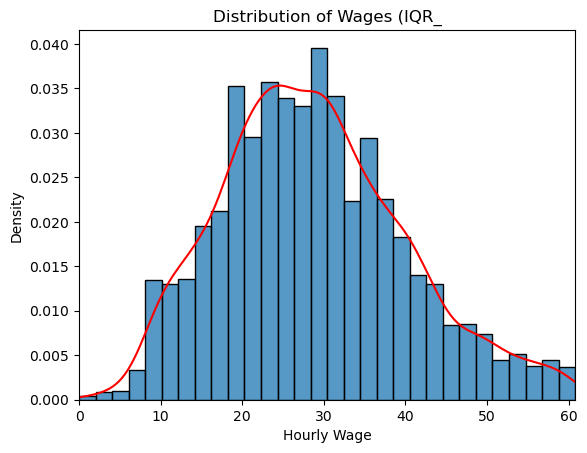

In [24]:
# Checking distribution of hourly wages on IQR df
ax = sns.histplot(rnurses_iqr, x='hrwage', stat='density')
sns.kdeplot(rnurses_iqr, x='hrwage', color="red")

plt.xlim(0, rnurses_iqr['hrwage'].max())
plt.title('Distribution of Wages (IQR_')
plt.xlabel('Hourly Wage');

The distribution of the plot is now much less skewed and approximates a normal distribution

## Chart Regression Analysis - Non-linear (Lowess) vs Linear (OLS)
Hourly wages on Age

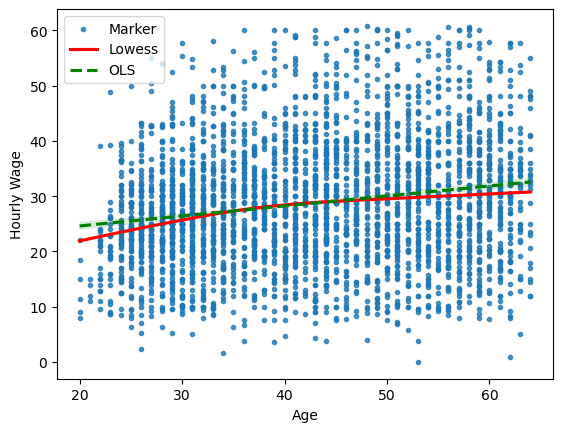

In [25]:
# Lowess
sns.regplot(rnurses_iqr, x = 'age', y = 'hrwage', marker= '.', fit_reg= True, lowess= True, line_kws = {'color':'red'})

# OLS
sns.regplot(rnurses_iqr, x = 'age', y = 'hrwage', scatter=False, line_kws={'color':'green', 'linestyle': '--'})

plt.xlabel('Age')
plt.ylabel('Hourly Wage')
plt.legend(['Marker', 'Lowess', 'OLS']); # Unable to figure out how to only show Lowess and OLS in legend, keeping as is

The Lowess and OLS plots are very similar and therefore a linear model should do a good job of finding a good fit

## Models
#### Model 1
Making a simple regression of `hrwage` on `age` with `female` as an explanatory variable and `agesq` to account for potential curvature in the data. Accounting for influence of gender on the hourly wage.

In [26]:
# Creating regression for model 1
reg1 = smf.ols('hrwage ~ age + agesq + female', data=rnurses_iqr).fit(cov_type="HC1")

#### Model 2
Adding education binaries as explanatory variables to account for education potentially influencing the hourly wages

In [27]:
# Creating regression for model 2
reg2 = smf.ols('hrwage ~ age + agesq + female + no_degree + associate + higher_edu', data=rnurses_iqr).fit(cov_type="HC1")

#### Model 3
Adding race binary variables as explanatory variables in order to account for race potentially influencing the hourly wage as well as adding `unionmme` to account for union membership potentially affecting hourly wages. . Also adding interaction term between `female` and `age` as well as `unionmme` and `age`

In [28]:
# Creating regression for model 3
reg3 = smf.ols('hrwage ~ age + agesq + female + no_degree + associate + higher_edu + black + asian + unionmme + unionmme*age + female*age', data=rnurses_iqr).fit(cov_type="HC1")

#### Model 4
Adding all binary variables accounting for children as well as marital status to account for families and/or children potentially influencing wages and an interaction term between the marital status binary variables and age

In [29]:
# Creating regression for model 4
reg4 = smf.ols('hrwage ~ age + agesq + female + no_degree + associate + higher_edu + black + asian + unionmme + unionmme*age +female*age +\
                one_child + two_child + three_plus_child + never_married + now_single + never_married*age + now_single*age', data=rnurses_iqr).fit(cov_type="HC1")

### Stargazer Results
Viewing results of stargazer for all regressions

In [30]:
# Viewing regression results with stargazer
sg = stargazer.Stargazer([reg1, reg2, reg3, reg4])

sg.covariate_order(['Intercept', 'age', 'agesq', 'female', 'female:age', 'no_degree', 'associate', 'higher_edu', 'black', 'asian', 'unionmme', 'unionmme:age', 
                           'one_child', 'two_child', 'three_plus_child', 'never_married', 'never_married:age', 'now_single', 'now_single:age'])
sg.rename_covariates({'one_child': 'Children: 1', 'two_child': 'Children: 2', 
                             'three_plus_child': 'Children: 3+', 'Intercept': 'Constant'})

# Adding RMSE for measurement in the full sample for each model
rmse_values = [round(rmse(x.fittedvalues, rnurses_iqr.hrwage), 3) for x in [reg1, reg2, reg3, reg4]]
sg.add_line('RMSE', rmse_values, location=stargazer.LineLocation.FOOTER_BOTTOM)

# Adding BIC for measurement in the full sample for each model
bic = [round(x.bic, 2) for x in [reg1, reg2, reg3, reg4]]
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)

sg

In the full sample the RMSE and BIC values point to model 3 being the best model to use for predictions. RMSE by it's nature will always decrease as complexity is added to models however the BIC penalizes overfitting. When viewing both together the BIC is the lowest in model 3 while the RMSE does not drop much more from model 3 to model 4. Cross-fold validation still needs to be done, however, which may change how model 3 is viewed in comparison

## Cross-fold validation

In [47]:
# Importing library for predictive analysis
from sklearn.model_selection import KFold

# Making 5 folds
k = KFold(n_splits=5, shuffle=True, random_state=True) # Setting a random state for cross-fold validation

In [48]:
# Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula

def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []

    # Calculating OLS for each fold

    for train_index, test_index in k.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict())]

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
    }


def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [49]:
# Running folds for each model

# Model 1
cv1 = cv_reg('hrwage~age+agesq+female', rnurses_iqr, k, 'HC1')

# Model 2
cv2 = cv_reg('hrwage~age+agesq+female+no_degree+associate+higher_edu', rnurses_iqr, k, 'HC1')

# Model 3
cv3 = cv_reg('hrwage~age+agesq+female+no_degree+associate+higher_edu+black+asian+unionmme+unionmme*age+female*age', rnurses_iqr, k, 'HC1')

# Model 4
cv4 = cv_reg('hrwage~age+agesq+female+no_degree+associate+higher_edu+black+asian+unionmme+unionmme*age+\
              female*age+one_child+two_child+three_plus_child+never_married+now_single+never_married*age+now_single*age', rnurses_iqr, k, 'HC1')

In [50]:
# Viewing results of cross-fold validation

# Creating list of cross validations
cv_list = [cv1, cv2, cv3, cv4]

# Displaying list
summarize_cv(cv_list)

,Model1,Model2,Model3,Model4
Fold1,11.192,10.829,10.575,10.548
Fold2,11.009,10.678,10.483,10.454
Fold3,11.094,10.727,10.531,10.505
Fold4,11.043,10.666,10.437,10.386
Fold5,11.114,10.749,10.520,10.494
Average,11.090,10.730,10.509,10.477


#### Cross-fold validation Results and Inference
Cross-fold validation results show a very similar output to the RMSE from the main sample. As such, it does not change our inference that model 3 is the best model to use for predictions.

As mentioned earlier, the more complex the model the more the RMSE will decrease. This is always true. The more complex the model, however, the more susceptible it can be to overfitting.

A very complex model for your original data can make for a great fit with the data that you are working with, however if you were to use an overly complex model with live data you may end up having a poor fit, or at best a worse fit than a model that might be much less complex. Since we are trying to make the best prediction possible in live data based on this original data, we must be conscious of our decisions when making models and trying not to overfit the models. This is why the BIC is important to view in tandem with the RMSE since (mentioned earlier as well) it penalizes overfitting. For these reasons, model 3 appears to be the best choice for use in predictions.

## Predictions
#### Using Model 3 for making predictions
Having selected model 3 as the best model for use in predictions, we will now select values in order check the prediction of the model. The following values will be selected for testing the first prediction:
- Bachelors: Yes
- Union member: Yes
- Age: 35
- Sex: Female
- Race: Black

In [32]:
# Disabling scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [51]:
# Checking to see if disabling scientific notation worked and also viewing the residuals for model 3
reg3.resid.describe()

count   3341.000
mean       0.000
std       10.515
min      -34.783
25%       -7.441
50%       -0.736
75%        6.527
max       35.131
dtype: float64

In [64]:
# Creating variable `pv` for assigning predictive values
pv = pd.DataFrame(pd.Series({
    "age":35,
    "agesq":35**2,
    "female":1,
    "no_degree":0,
    "associate":0,
    "higher_edu":0,
    "black":1,
    "asian":0,
    "unionmme":1,
    "hrwage":np.nan,
})).T
pv

,age,agesq,female,no_degree,associate,higher_edu,black,asian,unionmme,hrwage
0,35.000,1225.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,NaN


In [100]:
# Assigning first prediction to p1 and displaying prediction results, p1_95 with a 95% confidence interval and p1_80 with 80%
p1_95 = reg3.get_prediction(pv).summary_frame()
p1_80 = reg3.get_prediction(pv).summary_frame(alpha=.2)

df = pd.concat([p1_95, p1_80], axis=0, keys=['95%', '80%']).reset_index().groupby('level_0').value_counts().reset_index()
df.drop(columns=['level_1', 'count'], inplace=True)
df.rename(columns={'level_0': 'CI'}, inplace=True)
df.set_index('CI')

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
CI,,,,,,
80%,28.891,0.863,27.784,29.997,15.348,42.434
95%,28.891,0.863,27.198,30.583,8.178,49.603


From the prediction results based on the values that were inputted, based on model 3, we can see that the average predicted hourly wage of a woman who is black, 35, and has a bachelor's degree (nothing higher) and who is a union member is 28.89/hr. Of note, the confidence intervals are quite disparate for both the 80% and 95% values, with the 80% CI being between 15.35/hr and 42.43/hr and the 95% between 8.18/hr and 49.60/hr.

Now we will make another prediction with the same values only changing the union membership to 'No'

In [101]:
# Changing union membership to no and running prediction
pv2 = pd.DataFrame(pd.Series({
    "age":35,
    "agesq":35**2,
    "female":1,
    "no_degree":0,
    "associate":0,
    "higher_edu":0,
    "black":1,
    "asian":0,
    "unionmme":0,
    "hrwage":np.nan,
})).T

p2_95 = reg3.get_prediction(pv2).summary_frame()
p2_80 = reg3.get_prediction(pv2).summary_frame(alpha=.2)

df2 = pd.concat([p2_95, p2_80], axis=0, keys=['95%', '80%']).reset_index().groupby('level_0').value_counts().reset_index()
df2.drop(columns=['level_1', 'count'], inplace=True)
df2.rename(columns={'level_0': 'CI'}, inplace=True)
df2.set_index('CI')

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
CI,,,,,,
80%,24.549,0.683,23.673,25.424,11.022,38.075
95%,24.549,0.683,23.209,25.888,3.862,45.235


Here we can see that by simply changing the union membership value to 'No' the average predicted hourly wage drops to 24.55. The confidence interval remains large.

One more prediction will be run this time using the following values:
- Age: 31
- Sex: Female
- Race: White
- Union Member: No
- Bacherlors: Yes

These values are being used in comparison due to the sample size being larger for these predictive values

In [108]:
# Creating predictive values described above
pv3 = pd.DataFrame(pd.Series({
    "age":31,
    "agesq":31**2,
    "female":1,
    "no_degree":0,
    "associate":0,
    "higher_edu":0,
    "black":0,
    "asian":0,
    "unionmme":0,
    "hrwage":np.nan,
})).T

p3_95 = reg3.get_prediction(pv3).summary_frame()
p3_80 = reg3.get_prediction(pv3).summary_frame(alpha=.2)

df3 = pd.concat([p3_95, p3_80], axis=0, keys=['95%', '80%']).reset_index().groupby('level_0').value_counts().reset_index()
df3.drop(columns=['level_1', 'count'], inplace=True)
df3.rename(columns={'level_0': 'CI'}, inplace=True)
df3.set_index('CI')

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
CI,,,,,,
80%,27.616,0.296,27.237,27.995,14.113,41.120
95%,27.616,0.296,27.037,28.196,6.965,48.268


With these new predictive values we have a mean hourly wage of 27.61. The confidence intervals remain large.

#### Predictive Comparisons
For reference, a comparison in predictions will be made between Model 1 and Model 3 using the predictive values from pv3

In [110]:
# Generating an 80% CI comparison between models
p4 = reg1.get_prediction(pv3).summary_frame(alpha=.2)

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": p4[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p3_80[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,26.401,27.616
PI_low(80%),12.175,14.113
PI_high(80%),40.627,41.120


In [113]:
# Generating a 95% CI comparison between models
p5 = reg1.get_prediction(pv3).summary_frame()

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(95%)", "PI_high(95%)"],
        "Model1": p5[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": p3_95[["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model3
,,
Predicted,26.401,27.616
PI_low(95%),4.645,6.965
PI_high(95%),48.158,48.268


From the comparison of models we can see that there is a difference in the predicted values from the simplest model (model 1) to the more complex model (model 3). The confidence intervals are smaller, albeit slightly, and model 3 predicts a higher mean hourly wage average.